In [41]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
SEED = 8
random.seed(SEED)
np.random.seed(SEED)


In [42]:
stocks = ['A', 'GS']
start_date = "2021-01-01"
end_date = "2024-06-01"
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()


[*********************100%%**********************]  2 of 2 completed


,A,GS
Date,,
2021-01-04,116.195976,242.739670
2021-01-05,117.146004,248.171448
2021-01-06,120.358429,261.563354
2021-01-07,123.561073,267.150970
2021-01-08,124.442528,265.712830


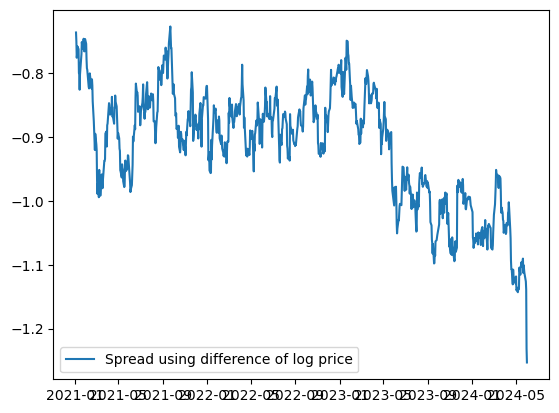

In [43]:
spread = np.log(df[stocks[0]]) - np.log(df[stocks[1]])
plt.plot(spread, label='Spread using difference of log price')
plt.legend()
plt.show()

asset1_returns = np.log(df[stocks[0]]).diff()
asset2_returns = np.log(df[stocks[1]]).diff()
spread_ma5 = spread.rolling(5).mean()
asset1_volatility = asset1_returns.rolling(20).std()
asset2_volatility = asset2_returns.rolling(20).std()

X = pd.DataFrame({'Asset1Returns': asset1_returns,
                  'Asset2Returns': asset2_returns,
                  'SpreadMA5': spread_ma5,
                  'Asset1Volatility': asset1_volatility,
                  'Asset2Volatility': asset2_volatility})
X = X.fillna(0)
y = spread


In [44]:
# split train/test set
train_size = int(len(spread) * 0.88)
train_X = X[:train_size]
test_X = X[train_size:]
train_y = y[:train_size]
test_y = y[train_size:]


In [45]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# use SVR to predict
svm_model = SVR(kernel='linear')
svm_model.fit(train_X, train_y)
train_pred = svm_model.predict(train_X)
print("Training RMSE: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = svm_model.predict(test_X)
print("Test RMSE: ", np.sqrt(mean_squared_error(test_y, test_pred)))


Training RMSE:  0.052559253435218826
Test RMSE:  0.0973172740342902


In [46]:
def score_fn(model, type="non_neural_net"):
    if type == "non_neural_net":
        test_pred = model.predict(test_X)
    else:
        test_pred = model(torch.Tensor(test_X.values)).detach().numpy()
    
    zscore = (spread[train_size:] - test_pred.mean()) / test_pred.std()
    entry_threshold = 2.0
    exit_threshold = 1.0
    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)
    
    for i in range(1, len(zscore)):
        if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
            stock1_position[i] = 1
            stock2_position[i] = -1
        elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
            stock1_position[i] = -1
            stock2_position[i] = 1
        elif abs(zscore[i]) < exit_threshold:
            stock1_position[i] = 0
            stock2_position[i] = 0
        else:
            stock1_position[i] = stock1_position[i-1]
            stock2_position[i] = stock2_position[i-1]
    
    stock1_returns = (test_X['Asset1Returns'] * stock1_position.shift(1)).fillna(0)
    stock2_returns = (test_X['Asset2Returns'] * stock2_position.shift(1)).fillna(0)
    total_returns = stock1_returns + stock2_returns
    cumulative_returns = (1 + total_returns).cumprod()
    return cumulative_returns, total_returns

# evaluate pnl
cumulative_returns, pnl = score_fn(svm_model)


In [47]:
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    sharpe = pnl.mean() / pnl.std()
    sharpe = sharpe * np.sqrt(252)
    print("")
    print("PERFORMANCE STATISTICS FOR " + label)
    print("Daily annualized sharpe: " + str(sharpe))
    print("Average annual returns: " + str(pnl.mean() * 252 * 100) + "%")
    print("Total returns: " + str(pnl.sum() * 100) + "%")
    highwatermark_df = cumpnl.cummax()
    drawdown_df = cumpnl - highwatermark_df
    maxdrawdown = drawdown_df.min()
    print("Max drawdown: " + str(maxdrawdown * 100) + "%")
    plt.plot(cumpnl.values, label=label)
    plt.legend()
    plt.title("Cumulative PNL chart")
    plt.show()

Training RMSE:  0.006233786744341672
Test RMSE:  0.03559361847471267

PERFORMANCE STATISTICS FOR MARKET NEUTRAL Random Forest
Daily annualized sharpe: -0.9823314267053289
Average annual returns: -19.37491833106501%
Total returns: -7.919113444840065%
Max drawdown: -16.2484906025961%


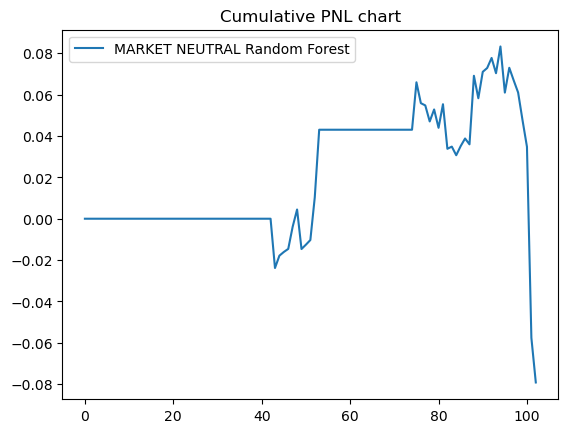

Epoch 0, Loss: 0.8512
Epoch 10, Loss: 0.5413
Epoch 20, Loss: 0.3190
Epoch 30, Loss: 0.1444
Epoch 40, Loss: 0.0346
Epoch 50, Loss: 0.0014
Epoch 60, Loss: 0.0067
Epoch 70, Loss: 0.0025
Epoch 80, Loss: 0.0014
Epoch 90, Loss: 0.0015
Training RMSE:  0.035260804
Test RMSE:  0.077618144

PERFORMANCE STATISTICS FOR MARKET NEUTRAL Neural Network
Daily annualized sharpe: -0.926414012560506
Average annual returns: -22.5557166549443%
Total returns: -9.219201648647868%
Max drawdown: -19.39190174515435%


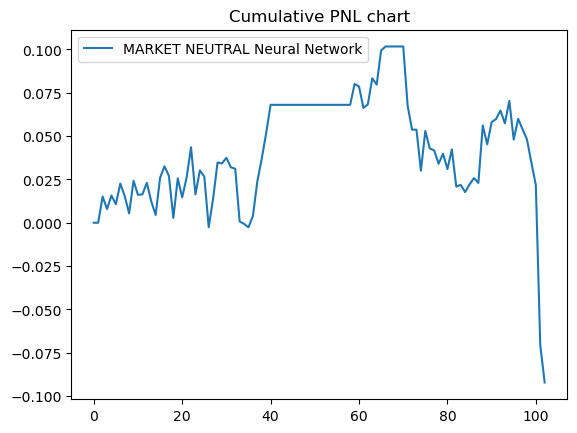

In [48]:
# random forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_X, train_y)
train_pred = rf_model.predict(train_X)
print("Training RMSE: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = rf_model.predict(test_X)
print("Test RMSE: ", np.sqrt(mean_squared_error(test_y, test_pred)))
cumulative_returns, pnl = score_fn(rf_model)
pnlPerformance(pnl, "MARKET NEUTRAL Random Forest")

# neural network
import torch
import torch.nn as nn
import torch.optim as optim

train_X_ts = torch.Tensor(train_X.values)
train_y_ts = torch.Tensor(train_y.values).view(-1, 1)
test_X_ts = torch.Tensor(test_X.values)
test_y_ts = torch.Tensor(test_y.values).view(-1, 1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

nn_model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = nn_model(train_X_ts)
    loss = criterion(outputs, train_y_ts)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {:.4f}".format(epoch, loss.item()))

train_pred = nn_model(train_X_ts).detach().numpy()
print("Training RMSE: ", np.sqrt(mean_squared_error(train_y_ts, train_pred)))
test_pred = nn_model(test_X_ts).detach().numpy()
print("Test RMSE: ", np.sqrt(mean_squared_error(test_y_ts, test_pred)))
cumulative_returns, pnl = score_fn(nn_model, type="nn")
pnlPerformance(pnl, "MARKET NEUTRAL Neural Network")

XGBoost Training RMSE:  0.0014979750756800411
XGBoost Test RMSE:  0.03809598324883729
XGBoost Performance:
Daily annualized Sharpe: 2.933373542703825
Average annual returns: 1.0378989527529763
Total returns: 0.33774172140765923
Max drawdown: -0.08842720515948178


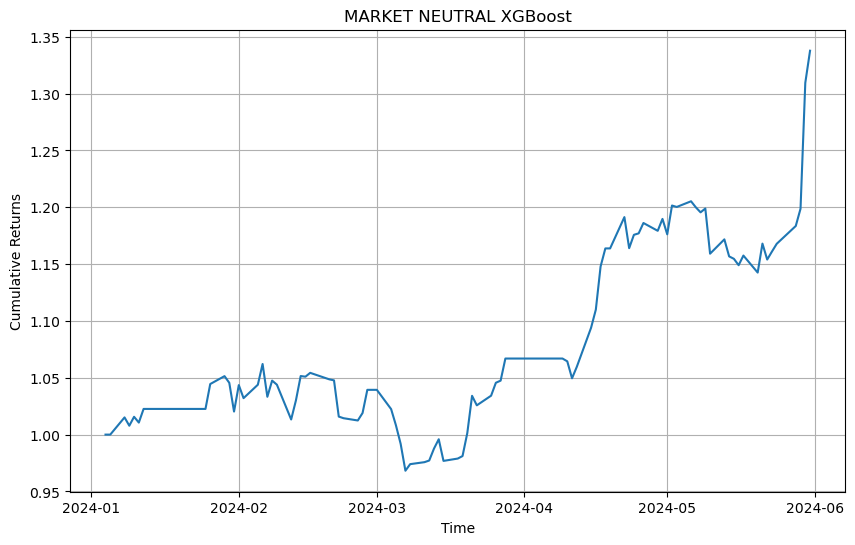

SVM Performance:
Daily annualized Sharpe: 3.636515037033289
Average annual returns: 1.4819796280227564
Total returns: 0.4499931015936609
Max drawdown: -0.052039085993151615


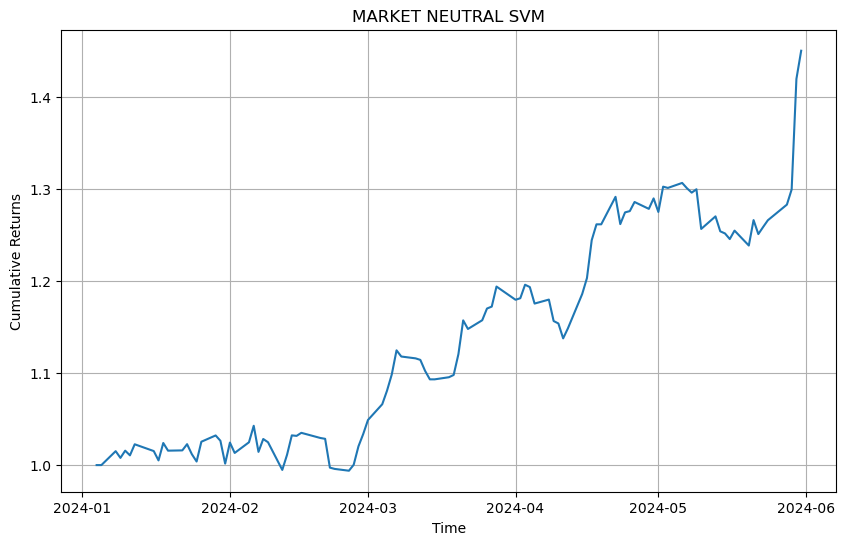

In [51]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Define the calculate_performance_metrics function
def calculate_performance_metrics(returns):
    daily_returns = returns.pct_change().dropna()
    mean_daily_return = daily_returns.mean()
    std_daily_return = daily_returns.std()
    sharpe_ratio = (mean_daily_return / std_daily_return) * np.sqrt(252)
    
    total_return = returns.iloc[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    
    cumulative = (1 + daily_returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    
    return sharpe_ratio, annual_return, total_return, max_drawdown

# Define the pnlPerformance function
def pnlPerformance(pnl, title):
    plt.figure(figsize=(10, 6))
    plt.plot(pnl)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()

# XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(train_X, train_y)
train_pred = xgb_model.predict(train_X)
print("XGBoost Training RMSE: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = xgb_model.predict(test_X)
print("XGBoost Test RMSE: ", np.sqrt(mean_squared_error(test_y, test_pred)))

# Parameter range for grid search
entry_thresholds = np.arange(0.5, 5.0, 0.5)
exit_thresholds = np.arange(0.1, 3.0, 0.5)

# Initialize variables to store the best parameters and maximum return
best_params = {'entry_threshold': None, 'exit_threshold': None}
max_return = -np.inf

# Grid search
for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        cumulative_returns, pnl = score_fn(xgb_model, type="non_neural_net", entry_threshold=entry_threshold, exit_threshold=exit_threshold)
        total_return = pnl.sum()
        if total_return > max_return:
            max_return = total_return
            best_params['entry_threshold'] = entry_threshold
            best_params['exit_threshold'] = exit_threshold

# Final evaluation using the best parameters
cumulative_returns, pnl = score_fn(xgb_model, type="non_neural_net", entry_threshold=best_params['entry_threshold'], exit_threshold=best_params['exit_threshold'])

# Calculate and print performance metrics
sharpe_ratio, annual_return, total_return, max_drawdown = calculate_performance_metrics(cumulative_returns)
print(f"XGBoost Performance:")
print(f"Daily annualized Sharpe: {sharpe_ratio}")
print(f"Average annual returns: {annual_return}")
print(f"Total returns: {total_return}")
print(f"Max drawdown: {max_drawdown}")

# Plot XGBoost cumulative returns
pnlPerformance(cumulative_returns, "MARKET NEUTRAL XGBoost")

# SVM model
best_params_svm = {'C': None, 'epsilon': None, 'entry_threshold': None, 'exit_threshold': None}
max_return_svm = -np.inf

# Grid search for SVM
C_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 0.2, 0.5]

for C in C_values:
    for epsilon in epsilon_values:
        svm_model = SVR(kernel='rbf', C=C, epsilon=epsilon)
        svm_model.fit(train_X, train_y)
        
        for entry_threshold in entry_thresholds:
            for exit_threshold in exit_thresholds:
                cumulative_returns, pnl = score_fn(svm_model, type="non_neural_net", entry_threshold=entry_threshold, exit_threshold=exit_threshold)
                total_return = pnl.sum()
                if total_return > max_return_svm:
                    max_return_svm = total_return
                    best_params_svm['C'] = C
                    best_params_svm['epsilon'] = epsilon
                    best_params_svm['entry_threshold'] = entry_threshold
                    best_params_svm['exit_threshold'] = exit_threshold

# Final evaluation using the best parameters
svm_model = SVR(kernel='rbf', C=best_params_svm['C'], epsilon=best_params_svm['epsilon'])
svm_model.fit(train_X, train_y)
cumulative_returns, pnl = score_fn(svm_model, type="non_neural_net", entry_threshold=best_params_svm['entry_threshold'], exit_threshold=best_params_svm['exit_threshold'])

# Calculate and print performance metrics
sharpe_ratio, annual_return, total_return, max_drawdown = calculate_performance_metrics(cumulative_returns)
print(f"SVM Performance:")
print(f"Daily annualized Sharpe: {sharpe_ratio}")
print(f"Average annual returns: {annual_return}")
print(f"Total returns: {total_return}")
print(f"Max drawdown: {max_drawdown}")

# Plot SVM cumulative returns
pnlPerformance(cumulative_returns, "MARKET NEUTRAL SVM")
